# EDA
Relatively quick check to see which features to drop/preprocess to get things going.

I. Inspect raw featurs and preprocess them to a numeric format.  
II. Analyse processed features + additional feature engineering.

In [2]:
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

% matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
raw = pd.read_csv("../data/titanic.csv")
raw.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# missing values
raw.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

## I. Raw Feature Inspection/Processing

Go through each feature and add/drop/process it accordingly

In [5]:
df = pd.DataFrame()

### 0. survived
The endogenous variable, not much to do here

In [6]:
# class imabalance
raw["survived"].mean()

0.3838383838383838

In [7]:
df["survived"] = raw["survived"]

### 1. ticket 
Drop to save time

In [8]:
raw = raw.drop(["ticket"], axis=1)

### 2. cabin
Use Cabin first letter (floor?) as feature

In [9]:
raw["cabin"].isnull().sum()

687

In [10]:
# survival rate per cabin floor
raw.groupby(raw["cabin"].str[0])["survived"].mean()

cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Name: survived, dtype: float64

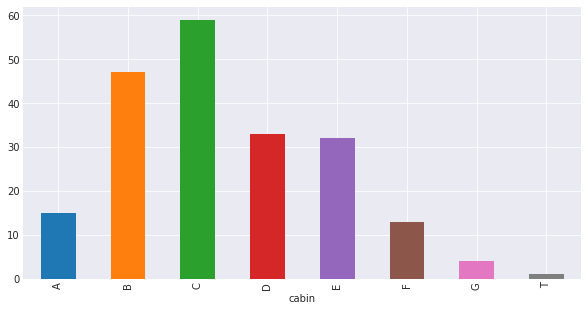

In [11]:
# distribution of cabins
raw.groupby(raw["cabin"].str[0])["survived"].count().plot(kind="bar")
plt.show()

In [12]:
# add feature
df["cabin_floor"] = np.log(LabelEncoder().fit_transform(raw["cabin"].str[0].fillna("")) + 1)

### 3. pclass
Keep pclass as is

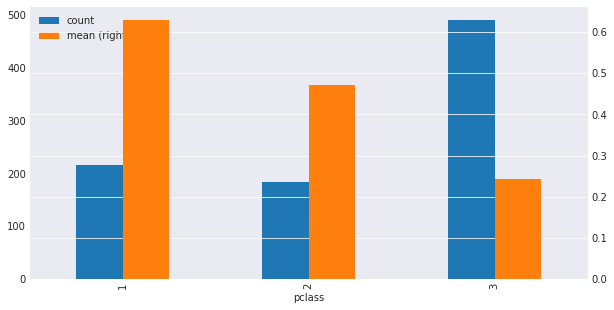

In [13]:
# distribution and survial rate based on pclass
raw.groupby("pclass")["survived"].describe()[["count", "mean"]].plot(kind="bar", secondary_y="mean")
plt.show()

In [14]:
# add to features
df["pclass"] = raw["pclass"]

### 4. sex
Use binary encoding

In [15]:
# conditionals
raw.groupby("sex")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,314.0,0.742038,0.438211,0.0,0.0,1.0,1.0,1.0
male,577.0,0.188908,0.391775,0.0,0.0,0.0,0.0,1.0


In [16]:
# add to features
df["sex"] = LabelEncoder().fit_transform(raw["sex"])

### 5. Age
Keep as is, attention not to impute with 0

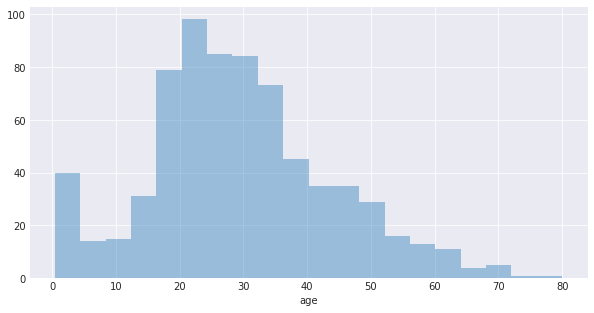

In [17]:
# Age distribution
sns.distplot(raw["age"].dropna(), kde=False)
plt.show()

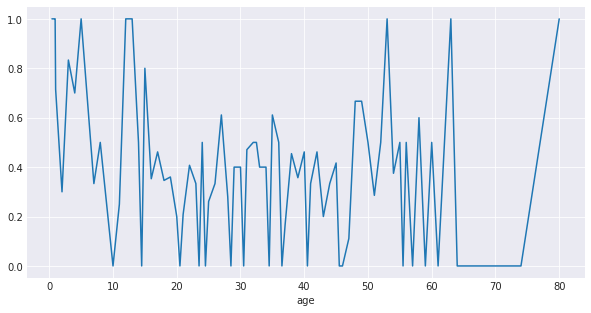

In [18]:
# conditional
raw.groupby("age")["survived"].mean().plot()
plt.show()

Extremes have a better survival rate - Expect to see a low linear correlation, parabolic corr would be a better indicator.  
Dropping the feature based on pearson corr would be a mistake.

In [19]:
# pearson corr
raw["age"].corr(raw["survived"])

-0.077221094572177656

In [20]:
# add feature
df["age"] = raw["age"]

### 6. fare
Has some extreme values, log it

corr raw: 0.257306522385


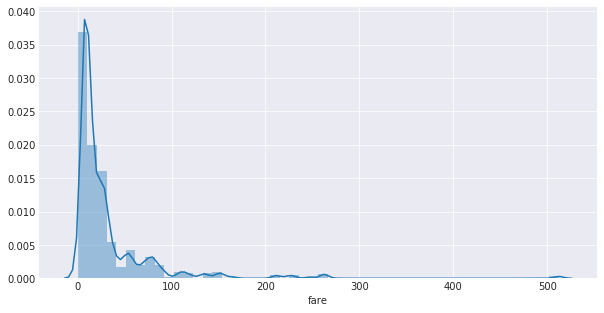

In [21]:
print("corr raw:", raw["fare"].corr(raw["survived"]))
sns.distplot(raw["fare"])
plt.show()

corr log: 0.329862128697


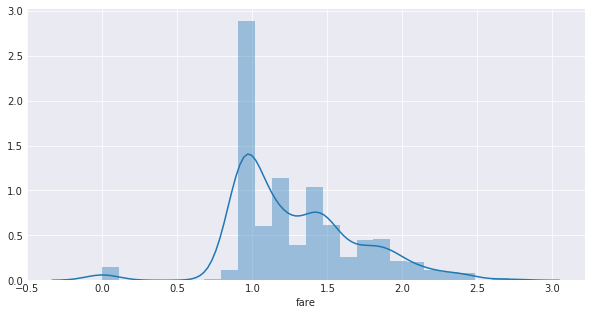

In [22]:
print("corr log:", raw["survived"].corr(np.log10(raw["fare"] + 1)))
sns.distplot(np.log10(raw["fare"] + 1))
plt.show()

In [23]:
df["fare"] = np.log10(raw["fare"] + 1)

### 7. name
Create features based on last name.  
name_mean_fare, name_count  
!!! Attention to train test split to avoid data leak!!!  

In [24]:
names = raw["name"].str.split(",").apply(lambda x: x[0])
names.value_counts().describe()

count    667.000000
mean       1.335832
std        0.854922
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: name, dtype: float64

In [25]:
names.value_counts().head()

Andersson    9
Sage         7
Goodwin      6
Johnson      6
Panula       6
Name: name, dtype: int64

In [26]:
name_feats = df.groupby(names)[["fare"]].mean()
name_feats["count"] = np.log(df.groupby(names)["survived"].count())
name_feats = name_feats.reset_index()
name_feats.head()

,name,fare,count
0,Abbing,0.931966,0.000000
1,Abbott,1.327359,0.693147
2,Abelson,1.397940,0.693147
3,Adahl,0.916454,0.000000
4,Adams,0.956649,0.000000


In [27]:
name_feats = pd.merge(names.to_frame(), name_feats, left_on="name", right_on="name")
df["name_mean_fare"] = name_feats["fare"]
df["name_count"] = name_feats["count"]

### 8 - 9. sibsp and parch
Log a bit as well

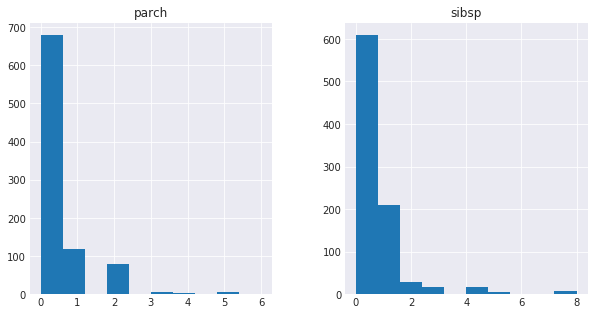

In [28]:
raw[["sibsp", "parch"]].hist()
plt.show()

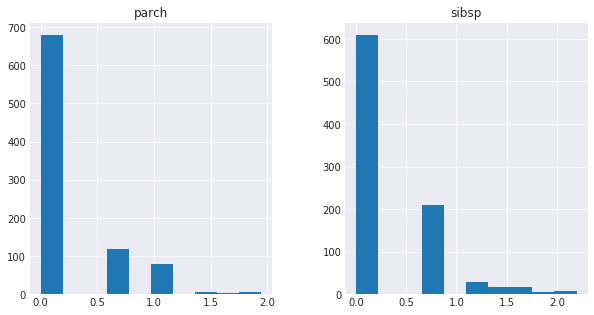

In [29]:
np.log(raw[["sibsp", "parch"]] + 1).hist()
plt.show()

In [30]:
# conditionals
raw.groupby("sibsp")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
sibsp,,,,,,,,
0,608.0,0.345395,0.475888,0.0,0.0,0.0,1.00,1.0
1,209.0,0.535885,0.499908,0.0,0.0,1.0,1.00,1.0
2,28.0,0.464286,0.507875,0.0,0.0,0.0,1.00,1.0
3,16.0,0.250000,0.447214,0.0,0.0,0.0,0.25,1.0
4,18.0,0.166667,0.383482,0.0,0.0,0.0,0.00,1.0
5,5.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
8,7.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


In [31]:
raw.groupby("parch")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
parch,,,,,,,,
0,678.0,0.343658,0.475279,0.0,0.0,0.0,1.0,1.0
1,118.0,0.550847,0.499529,0.0,0.0,1.0,1.0,1.0
2,80.0,0.500000,0.503155,0.0,0.0,0.5,1.0,1.0
3,5.0,0.600000,0.547723,0.0,0.0,1.0,1.0,1.0
4,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,5.0,0.200000,0.447214,0.0,0.0,0.0,0.0,1.0
6,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0


In [32]:
df[["sibsp", "parch"]] = np.log(raw[["sibsp", "parch"]] + 1)

### 10. Embarked
One hot encoding

In [33]:
# conditionals 
raw.groupby("embarked")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
embarked,,,,,,,,
C,168.0,0.553571,0.498608,0.0,0.0,1.0,1.0,1.0
Q,77.0,0.389610,0.490860,0.0,0.0,0.0,1.0,1.0
S,644.0,0.336957,0.473037,0.0,0.0,0.0,1.0,1.0


In [34]:
cols = ["embarked_" + str(i) for i in range(4)]
df = pd.concat([df, pd.DataFrame(LabelBinarizer().fit_transform(raw["embarked"].fillna("X")), columns=cols)], axis=1)

## II. Feature Analysis
Analysing the features produces in step I.  
Feature selection, decorrelation, outlier detection etc comes here  

In [35]:
df.describe()

,survived,cabin_floor,pclass,sex,age,fare,name_mean_fare,name_count,sibsp,parch,embarked_0,embarked_1,embarked_2,embarked_3
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.325570,2.308642,0.647587,29.699118,1.286487,1.286487,0.426683,0.281839,0.217682,0.188552,0.086420,0.722783,0.002245
std,0.486592,0.620293,0.836071,0.477990,14.526497,0.420852,0.408443,0.586137,0.462838,0.411680,0.391372,0.281141,0.447876,0.047351
min,0.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000,20.125000,0.949897,0.956149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,3.000000,1.000000,28.000000,1.189047,1.190332,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,3.000000,1.000000,38.000000,1.505150,1.498311,0.693147,0.693147,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,2.197225,3.000000,1.000000,80.000000,2.710396,2.710396,2.197225,2.197225,1.945910,1.000000,1.000000,1.000000,1.000000


### 1. Missing Values
Only age has to be imputed, creating separate feature with missing_age

In [36]:
df["missing_age"] = df["age"].isnull().astype(int)
df["age"] = df["age"].fillna(0)

### 2. Correlation
Some high correlations, but nothing being extreme

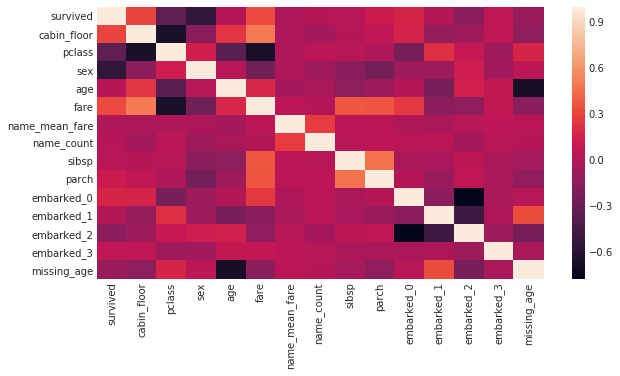

In [37]:
sns.heatmap(df.corr())
plt.show()

In [38]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pca = PCA().fit(RobustScaler().fit_transform(df))
pca.explained_variance_ratio_

array([  2.82003249e-01,   1.69872690e-01,   1.23587736e-01,
         9.23780064e-02,   8.80427404e-02,   5.85033870e-02,
         5.22455369e-02,   3.56251959e-02,   2.79840407e-02,
         2.21895917e-02,   1.98131884e-02,   1.67837110e-02,
         1.03838660e-02,   5.87060286e-04,   7.18025254e-33])

### 3. Distributions/Outliers
All are more or less well behaved, logged a bunch of geom distributed feats

survived


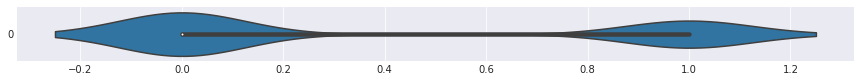

cabin_floor


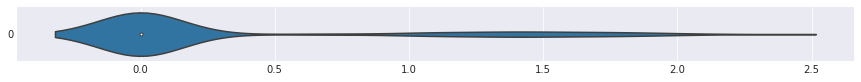

pclass


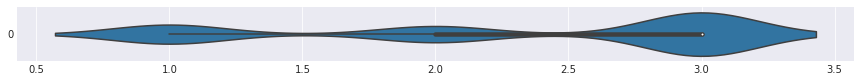

sex


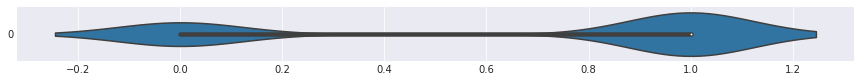

age


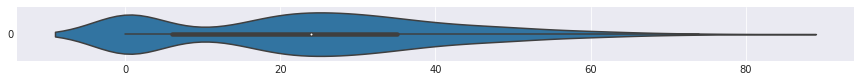

fare


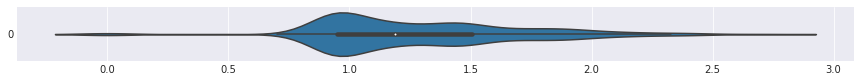

name_mean_fare


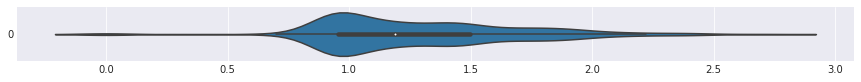

name_count


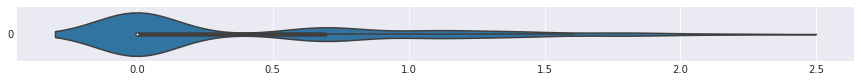

sibsp


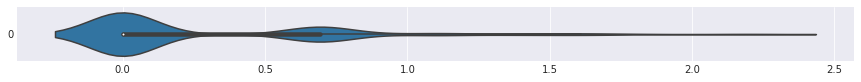

parch


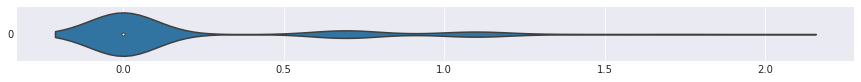

embarked_0


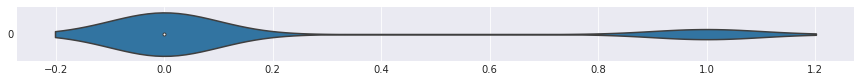

embarked_1


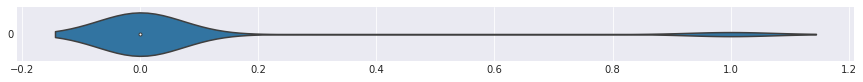

embarked_2


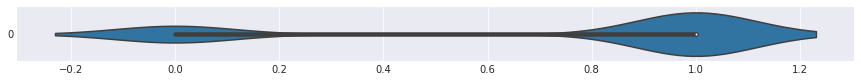

embarked_3


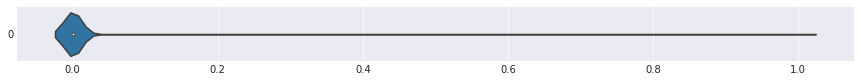

missing_age


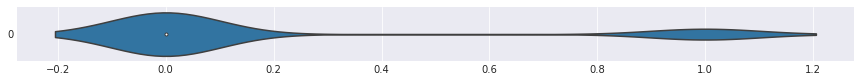

In [39]:
for col in df.columns:
    print(col)
    plt.figure(figsize=(15,1))
    sns.violinplot(data=df[col], orient="h")
    plt.show()

### 4. Final DF
Df will have to recomputed before modelling, just on the train split

In [40]:
df = pd.DataFrame(RobustScaler().fit_transform(df), columns=df.columns)
df.describe()

,survived,cabin_floor,pclass,sex,age,fare,name_mean_fare,name_count,sibsp,parch,embarked_0,embarked_1,embarked_2,embarked_3,missing_age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.325570,-0.691358,-0.352413,-0.006921,0.175488,0.177355,0.615574,0.406608,0.217682,0.188552,0.086420,-0.277217,0.002245,0.198653
std,0.486592,0.620293,0.836071,0.477990,0.606761,0.757946,0.753360,0.845618,0.667734,0.411680,0.391372,0.281141,0.447876,0.047351,0.399210
min,0.000000,0.000000,-2.000000,-1.000000,-0.827586,-2.141449,-2.195529,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,0.000000,-1.000000,-1.000000,-0.620690,-0.430704,-0.431943,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.379310,0.569296,0.568057,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.197225,0.000000,0.000000,1.931034,2.739919,2.803711,3.169925,3.169925,1.945910,1.000000,1.000000,0.000000,1.000000,1.000000


### 5. Embedded vis
Getting some nice separation already

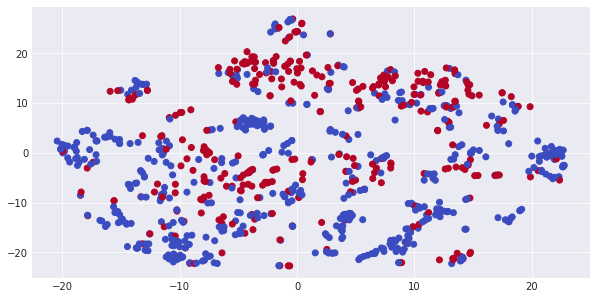

In [41]:
from sklearn.manifold import TSNE

embd = TSNE().fit_transform(df.drop("survived", axis=1))
plt.scatter(embd[:, 0], embd[:, 1], cmap="coolwarm", c=df["survived"])
plt.show()